# 1D parameter estimation using maximum likelihood estimation

This example will cover:

 - Use maximum likelihood estimation to optimise kernel parameters

In [1]:
from gpvecchia.vecchia import GPtideVecchia
import numpy as np
import matplotlib.pyplot as plt

## Generate some data

Start off with the same kernel as Example 1 and generate some data.

`GPvecchia` only accepts covariance functions that use a distance matrix. 

In [2]:
from numba import njit

@njit(cache=True)
def expquad_1d(x, xpr, params):
    eta, _ = params
    l = 1.0
    d = np.sum((x-xpr)**2)
    return eta**2. * np.exp(-d/(2*l*l))

In [3]:
####
# These are our kernel input parameters
noise = 0.5
η = 2
ℓ = 100
covfunc = expquad_1d

###
# Domain size parameters
dx = 25.
N = 1000
covparams = (η, ℓ)

# Input data points
xd = np.arange(0,dx*N,dx)[:,None]
xo = np.linspace(-10*dx,dx*N+dx*10,N*5)[:,None]

# A re-ordering function should always be specified - the default is no re-ordering
order_func = np.random.permutation
order_params = len(xd)

GP = GPtideVecchia(xd.copy(), xo, noise, covfunc, covparams, order_func=order_func, order_params=order_params, scale_coords=True)

# Use the .prior() method to obtain some samples
yd = GP.sample_prior(samples=1, add_noise=True)

In [5]:
y_mu, y_std = GP(yd.copy())

(216.25, 266.25)

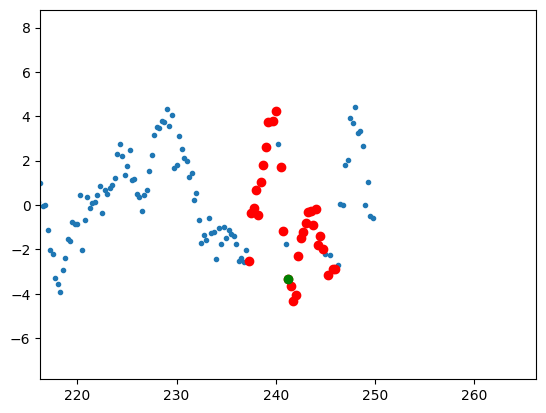

In [6]:
ix = 700
plt.plot(GP.xd, GP.yd, '.')
plt.plot(GP.xd[GP.nn_array[ix]], GP.yd[GP.nn_array[ix]], 'ro')
plt.plot(GP.xd[ix], GP.yd[ix], 'go')
plt.xlim(GP.xd[ix]-1*dx, GP.xd[ix]+1*dx)

(-250.0, 1275.2050410082018)

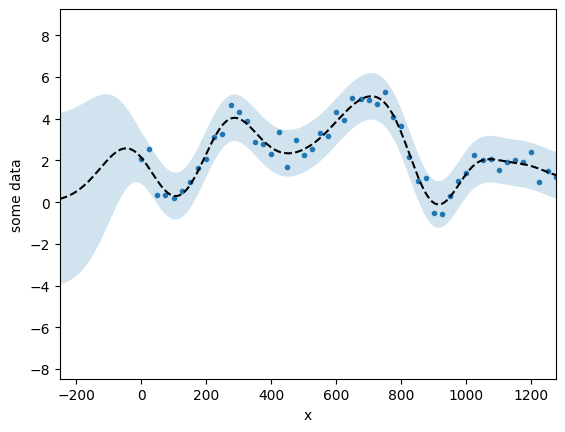

In [11]:
plt_ix = np.arange(0,300)
plt.figure()
plt.plot(xd, yd,'.')

plt.plot(xo, y_mu,'k--')
plt.fill_between(xo.flatten(),
                 (y_mu.flatten()-2*y_std.flatten()),
                 (y_mu.flatten()+2*y_std.flatten()),
                 alpha=0.2)

plt.ylabel('some data')
plt.xlabel('x')
plt.xlim([xo[plt_ix[0]],xo[plt_ix[-1]]])

## Inference

We now use the `gptide.mle` function do the parameter estimation. This calls the `scipy.optimize.minimize` routine.

Vecchia approximations can fail badly using gradient-based optimisers. 


In [8]:
from gptide import mle

GP.log_marg_likelihood(yd)

array([-249.96980295])

In [9]:
# Initial guess of the noise and covariance parameters (these can matter)
noise_ic = 0.1
covparams_ic = [1., 10.]

soln = mle(
    xd, yd, 
    covfunc, 
    covparams_ic,
    noise_ic,
    GPclass=GPtideVecchia,
    method='Nelder-Mead',
    verbose=True,
    gp_kwargs={'order_func':order_func, 'order_params':order_params, 'nnum':30, 'scale_coords':True})

print('Noise (true): {:3.2f}, |Noise| (mle): {:3.2f}'.format(noise, abs(soln['x'][0])))
print('ℓ (true): {:3.2f}, ℓ (mle): {:3.2f}'.format(covparams[0], soln['x'][1]))
print('η (true): {:3.2f}, η (mle): {:3.2f}'.format(covparams[1], soln['x'][2]))

[ 0.1  1.  10. ]
[2448.41128155]
[ 0.105  1.    10.   ]
[2446.6254097]
[ 0.1   1.05 10.  ]
[2271.37503343]
[ 0.1  1.  10.5]
[2388.28291854]
[ 0.10333333  1.03333333 10.33333333]
[2289.05183571]
[ 0.09722222  1.05555556 10.55555556]
[2193.73958863]
[ 0.09333333  1.08333333 10.83333333]
[2082.16562634]
[ 0.09777778  1.11111111 10.27777778]
[2065.64662191]
[ 0.09666667  1.16666667 10.16666667]
[1943.27626505]
[ 0.09        1.16666667 10.33333333]
[1929.39453171]
[ 0.08333333  1.23333333 10.33333333]
[1799.69684474]
[ 0.08222222  1.27222222 10.88888889]
[1690.7834833]
[ 0.07333333  1.38333333 11.33333333]
[1519.4724336]
[ 0.07555556  1.43888889 10.38888889]
[1529.86719168]
[ 0.05814815  1.53703704 11.2037037 ]
[1405.56986026]
[ 0.03888889  1.72222222 11.72222222]
[1294.81900021]
[ 0.04185185  1.7962963  11.96296296]
[1264.62784868]
[ 0.02111111  2.07777778 12.77777778]
[1207.18811878]
[1.33333333e-02 2.01666667e+00 1.35000000e+01]
[1179.10122226]
[-0.01777778  2.30555556 15.05555556]
[1146